<a href="https://colab.research.google.com/github/DanB1421/DATA602/blob/main/Using_Machine_Learning_to_Project_Individual_OPS_for_MLB_Players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Library and Data Loading

In [ ]:
# imports all necessary libraries for preprocessing data, analyzing data, and building/selecting/evaluating models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                   StandardScaler,
                                   RobustScaler)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.decomposition import PCA
from sklearn.ensemble import (GradientBoostingRegressor,
                              AdaBoostRegressor,
                              RandomForestRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor,
                              HistGradientBoostingRegressor,
                              VotingRegressor,
                              StackingRegressor)
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mounts Google Drive to retrieve data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Target Variable Preprocessing and Extraction

To create the target variable, OPS values are calculated for each player by year from 2001-2022. The teams are one-hot encoded and duplicate playerID and yearIDs are grouped to account for players who played for multiple teams in a season prior to the OPS calculation. Null OPS values are dropped to ensure only valid OPS data was used. The OPS statistic is then extracted to a 1D numpy array as the target variable (y)

In [ ]:
# pulls target variable data of interest. Drops columns unnecessary to preprocessing
df_offense_target = pd.read_csv("/content/drive/MyDrive/baseballdatabank-2023.1/core/Batting.csv")
df_offense_target = df_offense_target[df_offense_target['yearID'] >= 2001].reset_index(drop=True)
df_offense_target = df_offense_target.drop(['stint','lgID','G','R','RBI','SB','CS','SO','IBB','SH','GIDP'], axis=1)
df_offense_target = df_offense_target.sort_values(by=['playerID', 'yearID']).reset_index(drop=True)
df_offense_target

,playerID,yearID,teamID,AB,H,2B,3B,HR,BB,HBP,SF
0,aardsda01,2004,SFN,0,0,0,0,0,0,0.0,0.0
1,aardsda01,2006,CHN,2,0,0,0,0,0,0.0,0.0
2,aardsda01,2007,CHA,0,0,0,0,0,0,0.0,0.0
3,aardsda01,2008,BOS,1,0,0,0,0,0,0.0,0.0
4,aardsda01,2009,SEA,0,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31529,zuninmi01,2021,TBA,333,72,11,2,33,34,7.0,1.0
31530,zuninmi01,2022,TBA,115,17,3,0,5,6,1.0,1.0
31531,zychto01,2015,SEA,0,0,0,0,0,0,0.0,0.0
31532,zychto01,2016,SEA,0,0,0,0,0,0,0.0,0.0


In [ ]:
# one-hot encodes teamIDs and concatenates with the original dataframe while combining player and yearIDs that are the same (one-hot encoding teamID was performed to ensure players who played for multiple teams in the same season had offensive statistics summed for their whole season)
enc = OneHotEncoder(categories='auto')
feature_arr = enc.fit_transform(df_offense_target[['teamID']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
df_offense_target = pd.concat([df_offense_target, features], axis=1).drop(columns=['teamID'])
df_offense_target = df_offense_target.groupby(['playerID', 'yearID']).sum().reset_index()
df_offense_target

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF,...,teamID_PHI,teamID_PIT,teamID_SDN,teamID_SEA,teamID_SFN,teamID_SLN,teamID_TBA,teamID_TEX,teamID_TOR,teamID_WAS
0,aardsda01,2004,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,1,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28816,zuninmi01,2021,333,72,11,2,33,34,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28817,zuninmi01,2022,115,17,3,0,5,6,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28818,zychto01,2015,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28819,zychto01,2016,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# creates calculated OPS series from relevant offensive statistics
OBP = (df_offense_target['H'] + df_offense_target['BB'] + df_offense_target['HBP'])/(df_offense_target['AB'] + df_offense_target['BB'] + df_offense_target['HBP']+df_offense_target['SF'])
SLG = ((df_offense_target['H'] - (df_offense_target['2B'] + df_offense_target['3B'] + df_offense_target['HR'])) + (2*df_offense_target['2B']) + (3*df_offense_target['3B']) + (4*df_offense_target['HR']))/(df_offense_target['AB'])
OPS = OBP + SLG
OPS

0             NaN
1        0.000000
2             NaN
3        0.000000
4             NaN
           ...   
28816    0.859892
28817    0.499470
28818         NaN
28819         NaN
28820         NaN
Length: 28821, dtype: float64

In [ ]:
# creates a target dataframe with playerID and yearID as the labels for OPS
frame = {'OPS': OPS, 'playerID': df_offense_target['playerID'], 'yearID': df_offense_target['yearID']}
df_target = pd.DataFrame(frame)
df_target = df_target.dropna().reset_index(drop=True)
df_target

,OPS,playerID,yearID
0,0.000000,aardsda01,2006
1,0.000000,aardsda01,2008
2,0.000000,aardsda01,2015
3,0.000000,abadan01,2001
4,0.328173,abadan01,2003
...,...,...,...
20381,0.669447,zuninmi01,2018
20382,0.543864,zuninmi01,2019
20383,0.598095,zuninmi01,2020
20384,0.859892,zuninmi01,2021


In [ ]:
# extracts target variable (OPS) from df_target and converts into 1d numpy array
y = df_target['OPS'].to_numpy().reshape(-1,1)
y = y.ravel()
y.shape

(20386,)

# Feature Preprocessing and Extraction

Several steps are taken to preprocess the feature data into a usable array. First, a base feature dataframe is created from the dimensions of the target dataframe.

In [ ]:
# builds base for feature dataframe
df_feature = df_offense_target.drop(['AB','H','2B','3B','HR','BB','HBP','SF'], axis=1)
df_feature = pd.merge(df_target, df_feature, left_on=["playerID","yearID"], right_on=["playerID", "yearID"], how='left')
df_feature

,OPS,playerID,yearID,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BOS,teamID_CHA,teamID_CHN,...,teamID_PHI,teamID_PIT,teamID_SDN,teamID_SEA,teamID_SFN,teamID_SLN,teamID_TBA,teamID_TEX,teamID_TOR,teamID_WAS
0,0.000000,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,aardsda01,2008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,aardsda01,2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,abadan01,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328173,abadan01,2003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,0.669447,zuninmi01,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20382,0.543864,zuninmi01,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20383,0.598095,zuninmi01,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20384,0.859892,zuninmi01,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Next, the offensive statistics from players' previous 5 years are extracted. As with the target dataframe, team IDs are one-hot encoded and rows of offensive statistics are grouped by playerID and yearID to account for any player who played for multiple teams in a season. Additionally, any missing data is filled in with 0s. To ensure the proper feature dimensions are kept, the offensive statistics are merged on the playerID and yearID columns of the feature dataframe.

In [ ]:
# extracts data necessary for determining offensive statistics from previous seasons while dropping irrelevant columns (includes years 1996-2000 to find prior statistics for players who played at least one year prior to 2001)
df_offense = pd.read_csv("/content/drive/MyDrive/baseballdatabank-2023.1/core/Batting.csv")
df_offense = df_offense[df_offense['yearID'] >= 1996].reset_index(drop=True)
df_offense = df_offense.drop(['stint','lgID'],axis=1)
df_offense = df_offense.sort_values(by=['playerID', 'yearID']).reset_index(drop=True)
df_offense

,playerID,yearID,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aardsda01,2004,SFN,11,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,CHN,45,2,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
2,aardsda01,2007,CHA,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,BOS,47,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,SEA,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38023,zuninmi01,2021,TBA,109,333,64,72,11,2,33,62.0,0.0,0.0,34,132.0,0.0,7.0,0.0,1.0,7.0
38024,zuninmi01,2022,TBA,36,115,7,17,3,0,5,16.0,0.0,0.0,6,46.0,0.0,1.0,0.0,1.0,2.0
38025,zychto01,2015,SEA,13,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
38026,zychto01,2016,SEA,12,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# one-hot encodes teams and combines rows that have the same playerID and yearID (players who played for multiple teams) but drops the team columns as those already exist in the feature matrix
enc = OneHotEncoder(categories='auto')
feature_arr = enc.fit_transform(df_offense[['teamID']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
df_offense = pd.concat([df_offense, features], axis=1).drop(columns=['teamID'])
df_offense = df_offense.groupby(['playerID', 'yearID']).sum().reset_index()
df_offense = df_offense.drop(['teamID_ANA', 'teamID_ARI', 'teamID_ATL', 'teamID_BAL', 'teamID_BOS', 'teamID_CAL', 'teamID_CHA', 'teamID_CHN', 'teamID_CIN', 'teamID_CLE',
        'teamID_COL', 'teamID_DET', 'teamID_FLO', 'teamID_HOU', 'teamID_KCA', 'teamID_LAA', 'teamID_LAN', 'teamID_MIA', 'teamID_MIL',
        'teamID_MIN', 'teamID_ML4','teamID_MON', 'teamID_NYA', 'teamID_NYN', 'teamID_OAK', 'teamID_PHI', 'teamID_PIT', 'teamID_SDN', 'teamID_SEA',
        'teamID_SFN', 'teamID_SLN', 'teamID_TBA', 'teamID_TEX', 'teamID_TOR', 'teamID_WAS'],axis=1)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,0.0,0.0,34,132.0,0.0,7.0,0.0,1.0,7.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,0.0,0.0,6,46.0,0.0,1.0,0.0,1.0,2.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# adds the previous year's offensive statistics to the dataframe and fills missing values with 0s
df_offense['G_one_back'] = df_offense.groupby('playerID')['G'].shift(1)
df_offense['AB_one_back'] = df_offense.groupby('playerID')['AB'].shift(1)
df_offense['R_one_back'] = df_offense.groupby('playerID')['R'].shift(1)
df_offense['H_one_back'] = df_offense.groupby('playerID')['H'].shift(1)
df_offense['2B_one_back'] = df_offense.groupby('playerID')['2B'].shift(1)
df_offense['3B_one_back'] = df_offense.groupby('playerID')['3B'].shift(1)
df_offense['HR_one_back'] = df_offense.groupby('playerID')['HR'].shift(1)
df_offense['RBI_one_back'] = df_offense.groupby('playerID')['RBI'].shift(1)
df_offense['SB_one_back'] = df_offense.groupby('playerID')['SB'].shift(1)
df_offense['CS_one_back'] = df_offense.groupby('playerID')['CS'].shift(1)
df_offense['BB_one_back'] = df_offense.groupby('playerID')['BB'].shift(1)
df_offense['SO_one_back'] = df_offense.groupby('playerID')['SO'].shift(1)
df_offense['IBB_one_back'] = df_offense.groupby('playerID')['IBB'].shift(1)
df_offense['HBP_one_back'] = df_offense.groupby('playerID')['HBP'].shift(1)
df_offense['SH_one_back'] = df_offense.groupby('playerID')['SH'].shift(1)
df_offense['SF_one_back'] = df_offense.groupby('playerID')['SF'].shift(1)
df_offense['GIDP_one_back'] = df_offense.groupby('playerID')['GIDP'].shift(1)
df_offense = df_offense.fillna(0)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,RBI_one_back,SB_one_back,CS_one_back,BB_one_back,SO_one_back,IBB_one_back,HBP_one_back,SH_one_back,SF_one_back,GIDP_one_back
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,...,10.0,0.0,0.0,6.0,37.0,0.0,3.0,0.0,0.0,0.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,...,62.0,0.0,0.0,34.0,132.0,0.0,7.0,0.0,1.0,7.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# adds the offensive statistics from two years prior to the dataframe and fills missing values with 0s
df_offense['G_two_back'] = df_offense.groupby('playerID')['G'].shift(2)
df_offense['AB_two_back'] = df_offense.groupby('playerID')['AB'].shift(2)
df_offense['R_two_back'] = df_offense.groupby('playerID')['R'].shift(2)
df_offense['H_two_back'] = df_offense.groupby('playerID')['H'].shift(2)
df_offense['2B_two_back'] = df_offense.groupby('playerID')['2B'].shift(2)
df_offense['3B_two_back'] = df_offense.groupby('playerID')['3B'].shift(2)
df_offense['HR_two_back'] = df_offense.groupby('playerID')['HR'].shift(2)
df_offense['RBI_two_back'] = df_offense.groupby('playerID')['RBI'].shift(2)
df_offense['SB_two_back'] = df_offense.groupby('playerID')['SB'].shift(2)
df_offense['CS_two_back'] = df_offense.groupby('playerID')['CS'].shift(2)
df_offense['BB_two_back'] = df_offense.groupby('playerID')['BB'].shift(2)
df_offense['SO_two_back'] = df_offense.groupby('playerID')['SO'].shift(2)
df_offense['IBB_two_back'] = df_offense.groupby('playerID')['IBB'].shift(2)
df_offense['HBP_two_back'] = df_offense.groupby('playerID')['HBP'].shift(2)
df_offense['SH_two_back'] = df_offense.groupby('playerID')['SH'].shift(2)
df_offense['SF_two_back'] = df_offense.groupby('playerID')['SF'].shift(2)
df_offense['GIDP_two_back'] = df_offense.groupby('playerID')['GIDP'].shift(2)
df_offense = df_offense.fillna(0)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,RBI_two_back,SB_two_back,CS_two_back,BB_two_back,SO_two_back,IBB_two_back,HBP_two_back,SH_two_back,SF_two_back,GIDP_two_back
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,...,32.0,0.0,0.0,20.0,98.0,0.0,3.0,0.0,0.0,4.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,...,10.0,0.0,0.0,6.0,37.0,0.0,3.0,0.0,0.0,0.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# adds the offensive statistics from three years prior to the dataframe and fills missing values with 0s
df_offense['G_three_back'] = df_offense.groupby('playerID')['G'].shift(3)
df_offense['AB_three_back'] = df_offense.groupby('playerID')['AB'].shift(3)
df_offense['R_three_back'] = df_offense.groupby('playerID')['R'].shift(3)
df_offense['H_three_back'] = df_offense.groupby('playerID')['H'].shift(3)
df_offense['2B_three_back'] = df_offense.groupby('playerID')['2B'].shift(3)
df_offense['3B_three_back'] = df_offense.groupby('playerID')['3B'].shift(3)
df_offense['HR_three_back'] = df_offense.groupby('playerID')['HR'].shift(3)
df_offense['RBI_three_back'] = df_offense.groupby('playerID')['RBI'].shift(3)
df_offense['SB_three_back'] = df_offense.groupby('playerID')['SB'].shift(3)
df_offense['CS_three_back'] = df_offense.groupby('playerID')['CS'].shift(3)
df_offense['BB_three_back'] = df_offense.groupby('playerID')['BB'].shift(3)
df_offense['SO_three_back'] = df_offense.groupby('playerID')['SO'].shift(3)
df_offense['IBB_three_back'] = df_offense.groupby('playerID')['IBB'].shift(3)
df_offense['HBP_three_back'] = df_offense.groupby('playerID')['HBP'].shift(3)
df_offense['SH_three_back'] = df_offense.groupby('playerID')['SH'].shift(3)
df_offense['SF_three_back'] = df_offense.groupby('playerID')['SF'].shift(3)
df_offense['GIDP_three_back'] = df_offense.groupby('playerID')['GIDP'].shift(3)
df_offense = df_offense.fillna(0)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,RBI_three_back,SB_three_back,CS_three_back,BB_three_back,SO_three_back,IBB_three_back,HBP_three_back,SH_three_back,SF_three_back,GIDP_three_back
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,...,44.0,0.0,0.0,24.0,150.0,0.0,6.0,0.0,2.0,7.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,...,32.0,0.0,0.0,20.0,98.0,0.0,3.0,0.0,0.0,4.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# adds the offensive statistics from four years prior to the dataframe and fills missing values with 0s
df_offense['G_four_back'] = df_offense.groupby('playerID')['G'].shift(4)
df_offense['AB_four_back'] = df_offense.groupby('playerID')['AB'].shift(4)
df_offense['R_four_back'] = df_offense.groupby('playerID')['R'].shift(4)
df_offense['H_four_back'] = df_offense.groupby('playerID')['H'].shift(4)
df_offense['2B_four_back'] = df_offense.groupby('playerID')['2B'].shift(4)
df_offense['3B_four_back'] = df_offense.groupby('playerID')['3B'].shift(4)
df_offense['HR_four_back'] = df_offense.groupby('playerID')['HR'].shift(4)
df_offense['RBI_four_back'] = df_offense.groupby('playerID')['RBI'].shift(4)
df_offense['SB_four_back'] = df_offense.groupby('playerID')['SB'].shift(4)
df_offense['CS_four_back'] = df_offense.groupby('playerID')['CS'].shift(4)
df_offense['BB_four_back'] = df_offense.groupby('playerID')['BB'].shift(4)
df_offense['SO_four_back'] = df_offense.groupby('playerID')['SO'].shift(4)
df_offense['IBB_four_back'] = df_offense.groupby('playerID')['IBB'].shift(4)
df_offense['HBP_four_back'] = df_offense.groupby('playerID')['HBP'].shift(4)
df_offense['SH_four_back'] = df_offense.groupby('playerID')['SH'].shift(4)
df_offense['SF_four_back'] = df_offense.groupby('playerID')['SF'].shift(4)
df_offense['GIDP_four_back'] = df_offense.groupby('playerID')['GIDP'].shift(4)
df_offense = df_offense.fillna(0)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,RBI_four_back,SB_four_back,CS_four_back,BB_four_back,SO_four_back,IBB_four_back,HBP_four_back,SH_four_back,SF_four_back,GIDP_four_back
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,...,64.0,1.0,0.0,39.0,160.0,0.0,8.0,0.0,1.0,8.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,...,44.0,0.0,0.0,24.0,150.0,0.0,6.0,0.0,2.0,7.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# adds the offensive statistics from five years prior to the dataframe and fills missing values with 0s
df_offense['G_five_back'] = df_offense.groupby('playerID')['G'].shift(5)
df_offense['AB_five_back'] = df_offense.groupby('playerID')['AB'].shift(5)
df_offense['R_five_back'] = df_offense.groupby('playerID')['R'].shift(5)
df_offense['H_five_back'] = df_offense.groupby('playerID')['H'].shift(5)
df_offense['2B_five_back'] = df_offense.groupby('playerID')['2B'].shift(5)
df_offense['3B_five_back'] = df_offense.groupby('playerID')['3B'].shift(5)
df_offense['HR_five_back'] = df_offense.groupby('playerID')['HR'].shift(5)
df_offense['RBI_five_back'] = df_offense.groupby('playerID')['RBI'].shift(5)
df_offense['SB_five_back'] = df_offense.groupby('playerID')['SB'].shift(5)
df_offense['CS_five_back'] = df_offense.groupby('playerID')['CS'].shift(5)
df_offense['BB_five_back'] = df_offense.groupby('playerID')['BB'].shift(5)
df_offense['SO_five_back'] = df_offense.groupby('playerID')['SO'].shift(5)
df_offense['IBB_five_back'] = df_offense.groupby('playerID')['IBB'].shift(5)
df_offense['HBP_five_back'] = df_offense.groupby('playerID')['HBP'].shift(5)
df_offense['SH_five_back'] = df_offense.groupby('playerID')['SH'].shift(5)
df_offense['SF_five_back'] = df_offense.groupby('playerID')['SF'].shift(5)
df_offense['GIDP_five_back'] = df_offense.groupby('playerID')['GIDP'].shift(5)
df_offense = df_offense.fillna(0)
df_offense

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,RBI_five_back,SB_five_back,CS_five_back,BB_five_back,SO_five_back,IBB_five_back,HBP_five_back,SH_five_back,SF_five_back,GIDP_five_back
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34705,zuninmi01,2021,109,333,64,72,11,2,33,62.0,...,31.0,0.0,0.0,21.0,65.0,0.0,6.0,0.0,1.0,0.0
34706,zuninmi01,2022,36,115,7,17,3,0,5,16.0,...,64.0,1.0,0.0,39.0,160.0,0.0,8.0,0.0,1.0,8.0
34707,zychto01,2015,13,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34708,zychto01,2016,12,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# drops the statistics from the current year of analysis and filters so the dataframe is the same dimensionally as the feature dataframe (drops data for years 1996-2000)
df_offense = df_offense.drop(['G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP'],axis=1)
df_offense = df_offense[df_offense['yearID'] >= 2001].reset_index(drop=True)
df_offense = df_offense
df_offense

,playerID,yearID,G_one_back,AB_one_back,R_one_back,H_one_back,2B_one_back,3B_one_back,HR_one_back,RBI_one_back,...,RBI_five_back,SB_five_back,CS_five_back,BB_five_back,SO_five_back,IBB_five_back,HBP_five_back,SH_five_back,SF_five_back,GIDP_five_back
0,aardsda01,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2007,45.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28816,zuninmi01,2021,28.0,75.0,8.0,11.0,4.0,0.0,4.0,10.0,...,31.0,0.0,0.0,21.0,65.0,0.0,6.0,0.0,1.0,0.0
28817,zuninmi01,2022,109.0,333.0,64.0,72.0,11.0,2.0,33.0,62.0,...,64.0,1.0,0.0,39.0,160.0,0.0,8.0,0.0,1.0,8.0
28818,zychto01,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28819,zychto01,2016,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# merges preprocessed offensive data into the feature dataframe
df_feature = pd.merge(df_feature, df_offense, left_on=["playerID","yearID"], right_on=["playerID", "yearID"], how='left')
df_feature

,OPS,playerID,yearID,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BOS,teamID_CHA,teamID_CHN,...,RBI_five_back,SB_five_back,CS_five_back,BB_five_back,SO_five_back,IBB_five_back,HBP_five_back,SH_five_back,SF_five_back,GIDP_five_back
0,0.000000,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,aardsda01,2008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,aardsda01,2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,abadan01,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328173,abadan01,2003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,0.669447,zuninmi01,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,1.0,0.0,16.0,49.0,0.0,3.0,0.0,1.0,5.0
20382,0.543864,zuninmi01,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.0,0.0,3.0,17.0,158.0,1.0,17.0,0.0,4.0,12.0
20383,0.598095,zuninmi01,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,0.0,1.0,21.0,132.0,0.0,5.0,8.0,2.0,6.0
20384,0.859892,zuninmi01,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,0.0,0.0,21.0,65.0,0.0,6.0,0.0,1.0,0.0


Then, the previous years' position is filtered from fielding data. As with the previous dataframes, team IDs are one-hot encoded and rows of fielding statistics are grouped by playerID and year ID for any player who played for multiple teams in a season. The primary position is determined by finding the maximum number of games and innings played at each position. Ties are broken by keeping the last observed rows, and the final position dataset is merged on the feature dataframe by playerID and yearID.

In [ ]:
# extracts necessary information for fielding data to determine previous year's position
df_fielding = pd.read_csv("/content/drive/MyDrive/baseballdatabank-2023.1/core/Fielding.csv")
df_fielding = df_fielding[df_fielding['yearID'] >= 2000].reset_index(drop=True)
df_fielding = df_fielding[df_fielding['yearID'] <= 2021].reset_index(drop=True)
df_fielding = df_fielding.drop(['stint','lgID','GS','PO','A','E','DP','PB','WP','SB','CS','ZR'],axis=1)
df_fielding = df_fielding.rename(columns={'yearID':'prevyearID'})
df_fielding['yearID'] = df_fielding['prevyearID'] + 1
df_fielding = df_fielding.drop(['prevyearID'],axis=1)
df_fielding = df_fielding.sort_values(by=['playerID', 'yearID']).reset_index(drop=True)
df_fielding

,playerID,teamID,POS,G,InnOuts,yearID
0,aardsda01,SFN,P,11,32.0,2005
1,aardsda01,CHN,P,45,159.0,2007
2,aardsda01,CHA,P,25,97.0,2008
3,aardsda01,BOS,P,47,146.0,2009
4,aardsda01,SEA,P,73,214.0,2010
...,...,...,...,...,...,...
40592,zuninmi01,TBA,C,28,647.0,2021
40593,zuninmi01,TBA,C,105,2581.0,2022
40594,zychto01,SEA,P,13,55.0,2016
40595,zychto01,SEA,P,12,41.0,2017


In [ ]:
# one-hot encodes positions and teams and adds to df_fielding dataframe while summing duplicate playerID and yearID rows
enc = OneHotEncoder(categories='auto')
feature_arr = enc.fit_transform(df_fielding[['teamID','POS']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
df_fielding = pd.concat([df_fielding, features], axis=1).drop(columns=['teamID','POS'])
df_fielding = df_fielding.groupby(['playerID', 'yearID','POS_1B','POS_2B','POS_3B','POS_C','POS_OF','POS_P','POS_SS']).sum().reset_index()
df_fielding

,playerID,yearID,POS_1B,POS_2B,POS_3B,POS_C,POS_OF,POS_P,POS_SS,G,...,teamID_PHI,teamID_PIT,teamID_SDN,teamID_SEA,teamID_SFN,teamID_SLN,teamID_TBA,teamID_TEX,teamID_TOR,teamID_WAS
0,aardsda01,2005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2007,0.0,0.0,0.0,0.0,0.0,1.0,0.0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aardsda01,2008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2009,0.0,0.0,0.0,0.0,0.0,1.0,0.0,47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2010,0.0,0.0,0.0,0.0,0.0,1.0,0.0,73,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37600,zuninmi01,2021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37601,zuninmi01,2022,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37602,zychto01,2016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37603,zychto01,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# modifies df_fielding to have the previous year's position with the most games and/or innings played (if that year's position is not present, missing value replaced with 0) and selects the last entry for any player with a tie in innings
df_fielding_mod = df_fielding.groupby(['playerID','yearID']).agg({'G':'max'}).reset_index()
df_fielding_mod = df_fielding.groupby(['playerID','yearID']).agg({'InnOuts':'max'}).reset_index()
df_fielding = pd.merge(df_fielding_mod, df_fielding, left_on=['playerID','yearID','InnOuts'], right_on=['playerID', 'yearID','InnOuts'], how='left')
df_fielding = df_fielding.drop(['InnOuts','teamID_ANA', 'teamID_ARI', 'teamID_ATL', 'teamID_BAL', 'teamID_BOS', 'teamID_CHA', 'teamID_CHN', 'teamID_CIN', 'teamID_CLE',
        'teamID_COL', 'teamID_DET', 'teamID_FLO', 'teamID_HOU', 'teamID_KCA', 'teamID_LAA', 'teamID_LAN', 'teamID_MIA', 'teamID_MIL',
        'teamID_MIN', 'teamID_MON', 'teamID_NYA', 'teamID_NYN', 'teamID_OAK', 'teamID_PHI', 'teamID_PIT', 'teamID_SDN', 'teamID_SEA',
        'teamID_SFN', 'teamID_SLN', 'teamID_TBA', 'teamID_TEX', 'teamID_TOR', 'teamID_WAS','G'],axis=1)
df_fielding['prevPOS_1B'] = df_fielding.groupby('playerID')['POS_1B'].shift(1).fillna(0)
df_fielding['prevPOS_2B'] = df_fielding.groupby('playerID')['POS_2B'].shift(1).fillna(0)
df_fielding['prevPOS_3B'] = df_fielding.groupby('playerID')['POS_3B'].shift(1).fillna(0)
df_fielding['prevPOS_C'] = df_fielding.groupby('playerID')['POS_C'].shift(1).fillna(0)
df_fielding['prevPOS_OF'] = df_fielding.groupby('playerID')['POS_OF'].shift(1).fillna(0)
df_fielding['prevPOS_P'] = df_fielding.groupby('playerID')['POS_P'].shift(1).fillna(0)
df_fielding['prevPOS_SS'] = df_fielding.groupby('playerID')['POS_SS'].shift(1).fillna(0)
df_fielding = df_fielding.drop(['POS_1B','POS_2B','POS_3B','POS_C','POS_OF','POS_P','POS_SS'],axis=1)
df_fielding = df_fielding.drop_duplicates(subset=['playerID','yearID'],keep='last').reset_index(drop=True)
df_fielding

,playerID,yearID,prevPOS_1B,prevPOS_2B,prevPOS_3B,prevPOS_C,prevPOS_OF,prevPOS_P,prevPOS_SS
0,aardsda01,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2007,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,aardsda01,2008,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,aardsda01,2009,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,aardsda01,2010,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28363,zuninmi01,2021,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28364,zuninmi01,2022,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28365,zychto01,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28366,zychto01,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# merges the preprocessed fielding data into the feature dataframe and fills missing values with 0s
df_feature = pd.merge(df_feature, df_fielding, left_on=["playerID","yearID"], right_on=["playerID", "yearID"], how='left')
df_feature = df_feature.fillna(0.0)
df_feature

,OPS,playerID,yearID,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BOS,teamID_CHA,teamID_CHN,...,SH_five_back,SF_five_back,GIDP_five_back,prevPOS_1B,prevPOS_2B,prevPOS_3B,prevPOS_C,prevPOS_OF,prevPOS_P,prevPOS_SS
0,0.000000,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,aardsda01,2008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,aardsda01,2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,abadan01,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328173,abadan01,2003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,0.669447,zuninmi01,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20382,0.543864,zuninmi01,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20383,0.598095,zuninmi01,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,2.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20384,0.859892,zuninmi01,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Further information is added to the feature dataframe in the form of awards from the previous year. The previous year's awards are one-hot encoded, and each group of awards a player wins in a season is grouped in a row by playerID. This is again merged on the feature dataframe by playerID and yearID, with missing data being filled with 0s.

In [ ]:
# extracts necessary information from awards data to determine the previous year's awards
df_awards = pd.read_csv('/content/drive/MyDrive/baseballdatabank-2023.1/contrib/AwardsPlayers.csv')
df_awards = df_awards.drop(columns=['tie','lgID', 'notes'])
df_awards = df_awards[df_awards['yearID'] >= 2000].reset_index(drop=True)
df_awards = df_awards.rename(columns={'yearID':'prevyearID'})
df_awards['yearID'] = df_awards['prevyearID'] + 1
df_awards = df_awards.drop(['prevyearID'],axis=1)
df_awards

,playerID,awardID,yearID
0,justida01,ALCS MVP,2001
1,jeterde01,All-Star Game MVP,2001
2,jeterde01,Babe Ruth Award,2001
3,stottto01,Branch Rickey Award,2001
4,martipe02,Cy Young Award,2001
...,...,...,...
1569,reynobr01,TSN All-Star,2022
1570,scherma01,TSN All-Star,2022
1571,haderjo01,TSN All-Star,2022
1572,friedma01,Silver Slugger,2022


In [ ]:
# one-hot encodes awards categories and adds to df_awards dataframe while making sure to combine awards for each individual playerID and yearID
enc = OneHotEncoder(categories='auto')
feature_arr = enc.fit_transform(df_awards[['awardID']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
df_awards = pd.concat([df_awards, features], axis=1).drop(columns=['awardID'])
df_awards = df_awards.groupby(['playerID', 'yearID']).sum().reset_index()
df_awards

,playerID,yearID,awardID_ALCS MVP,awardID_All-Star Game MVP,awardID_Babe Ruth Award,awardID_Branch Rickey Award,awardID_Comeback Player of the Year,awardID_Cy Young Award,awardID_Gold Glove,awardID_Hank Aaron Award,...,awardID_Rookie of the Year,awardID_SIlver Slugger,awardID_Silver Slugger,awardID_TSN All-Star,awardID_TSN Fireman of the Year,awardID_TSN Major League Player of the Year,awardID_TSN Pitcher of the Year,awardID_TSN Reliever of the Year,awardID_Triple Crown,awardID_World Series MVP
0,abreubo01,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abreubo01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abreujo02,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abreujo02,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abreujo02,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,zimmery01,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,zimmery01,2018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1018,zitoba01,2003,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1019,zitoba01,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# merges the preprocessed awards data into the feature dataframe and fills missing values with 0s
df_feature = pd.merge(df_feature, df_awards, left_on=["playerID","yearID"], right_on=["playerID", "yearID"], how='left')
df_feature = df_feature.fillna(0.0)
df_feature

,OPS,playerID,yearID,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BOS,teamID_CHA,teamID_CHN,...,awardID_Rookie of the Year,awardID_SIlver Slugger,awardID_Silver Slugger,awardID_TSN All-Star,awardID_TSN Fireman of the Year,awardID_TSN Major League Player of the Year,awardID_TSN Pitcher of the Year,awardID_TSN Reliever of the Year,awardID_Triple Crown,awardID_World Series MVP
0,0.000000,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,aardsda01,2008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,aardsda01,2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,abadan01,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328173,abadan01,2003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,0.669447,zuninmi01,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20382,0.543864,zuninmi01,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20383,0.598095,zuninmi01,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20384,0.859892,zuninmi01,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Additional offensive statistics in the form of the previous year's playoff offensive statistics are also added to the feature dataframe. The rounds are one-hot encoded and each row grouped by playerID to ensure that each player's full postseason offensive statistics each year are accounted for. This is again merged on the feature dataframe by playerID and yearID, with missing data being filled with 0s.

In [ ]:
# extracts necessary information from playoff offense data to determine the previous year's offensive statistics
df_playoff_offense = pd.read_csv("/content/drive/MyDrive/baseballdatabank-2023.1/core/BattingPost.csv")
df_playoff_offense = df_playoff_offense[df_playoff_offense['yearID'] >= 2000].reset_index(drop=True)
df_playoff_offense = df_playoff_offense[df_playoff_offense['yearID'] <= 2021].reset_index(drop=True)
df_playoff_offense = df_playoff_offense.rename(columns={'yearID': 'prevyearID'})
df_playoff_offense['yearID'] = df_playoff_offense['prevyearID'] + 1
df_playoff_offense = df_playoff_offense.drop(['prevyearID','lgID','teamID'],axis=1)
df_playoff_offense = df_playoff_offense.rename(columns={'G':'G_previous_playoff',
                                                        'AB':'AB_previous_playoff',
                                                        'R':'R_previous_playoff',
                                                        'H':'H_previous_playoff',
                                                        '2B':'2B_previous_playoff',
                                                        '3B':'3B_previous_playoff',
                                                        'HR':'HR_previous_playoff',
                                                        'RBI':'RBI_previous_playoff',
                                                        'SB':'SB_previous_playoff',
                                                        'CS':'CS_previous_playoff',
                                                        'BB':'BB_previous_playoff',
                                                        'SO':'SO_previous_playoff',
                                                        'IBB':'IBB_previous_playoff',
                                                        'HBP':'HBP_previous_playoff',
                                                        'SH':'SH_previous_playoff',
                                                        'SF':'SF_previous_playoff',
                                                        'GIDP':'GIDP_previous_playoff'})
df_playoff_offense

,round,playerID,G_previous_playoff,AB_previous_playoff,R_previous_playoff,H_previous_playoff,2B_previous_playoff,3B_previous_playoff,HR_previous_playoff,RBI_previous_playoff,SB_previous_playoff,CS_previous_playoff,BB_previous_playoff,SO_previous_playoff,IBB_previous_playoff,HBP_previous_playoff,SH_previous_playoff,SF_previous_playoff,GIDP_previous_playoff,yearID
0,ALDS2,abbotje01,1,1,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,2001
1,NLCS,abbotku01,2,3,0,0,0,0,0,0,0,0.0,0,2,0,0.0,0.0,0.0,0.0,2001
2,NLDS2,abbotku01,1,2,0,0,0,0,0,0,0,0.0,0,1,0,0.0,0.0,0.0,0.0,2001
3,WS,abbotku01,5,8,0,2,1,0,0,0,0,0.0,1,3,0,0.0,0.0,0.0,0.0,2001
4,ALCS,abbotpa01,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,WS,wrighky01,2,1,0,0,0,0,0,0,0,0.0,0,1,0,0.0,0.0,0.0,0.0,2022
8154,NLDS2,yastrmi01,5,13,0,0,0,0,0,0,0,0.0,0,4,0,0.0,0.0,0.0,0.0,2022
8155,NLDS1,yelicch01,4,15,1,3,0,0,0,0,1,0.0,2,8,0,0.0,0.0,0.0,1.0,2022
8156,NLDS1,ynoahu01,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,2022


In [ ]:
# one-hot encodes playoff rounds and adds to df_playoff_offense dataframe while making sure to combine statistics for each individual playerID and yearID
enc = OneHotEncoder(categories='auto')
feature_arr = enc.fit_transform(df_playoff_offense[['round']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
df_playoff_offense = pd.concat([df_playoff_offense, features], axis=1).drop(columns=['round'])
df_playoff_offense = df_playoff_offense.groupby(['playerID', 'yearID']).sum().reset_index()
df_playoff_offense

,playerID,yearID,G_previous_playoff,AB_previous_playoff,R_previous_playoff,H_previous_playoff,2B_previous_playoff,3B_previous_playoff,HR_previous_playoff,RBI_previous_playoff,...,round_ALWC4,round_NLCS,round_NLDS1,round_NLDS2,round_NLWC,round_NLWC1,round_NLWC2,round_NLWC3,round_NLWC4,round_WS
0,abadfe01,2015,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abbotje01,2001,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abbotku01,2001,8,13,0,2,1,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,abbotpa01,2001,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abbotpa01,2002,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,zobribe01,2018,9,26,3,4,2,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4834,zobribe01,2019,1,6,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4835,zumayjo01,2007,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4836,zuninmi01,2021,19,53,4,9,0,0,4,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# # merges the preprocessed playoff offense data into the feature dataframe and fills missing values with 0s
df_feature = pd.merge(df_feature, df_playoff_offense, left_on=["playerID","yearID"], right_on=["playerID", "yearID"], how='left')
df_feature = df_feature.fillna(0)
df_feature

,OPS,playerID,yearID,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BOS,teamID_CHA,teamID_CHN,...,round_ALWC4,round_NLCS,round_NLDS1,round_NLDS2,round_NLWC,round_NLWC1,round_NLWC2,round_NLWC3,round_NLWC4,round_WS
0,0.000000,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,aardsda01,2008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,aardsda01,2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,abadan01,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328173,abadan01,2003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,0.669447,zuninmi01,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20382,0.543864,zuninmi01,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20383,0.598095,zuninmi01,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20384,0.859892,zuninmi01,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The completed feature dataframe, minus the target variable OPS column and identifying playerID and yearID columns, is converted into a numpy array so analysis can be performed.

In [ ]:
# converts the feature dataframe (minus the OPS (target variable), playerID and yearID (target variable labels)) into a 20386 by 186 numpy array
X = df_feature[df_feature.columns[3:]].to_numpy()
X.shape

(20386, 186)

# Model Selection



Exploratory analysis was performed to examine which scaler would work best for the features prior to running model selection

<Axes: >

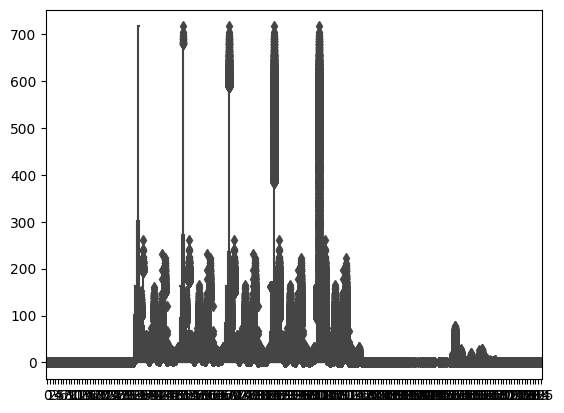

In [ ]:
# creates a stacked boxplot to examine feature distribution prior to scaling
f, ax = plt.subplots()
sns.boxplot(data=X, ax=ax)

<Axes: >

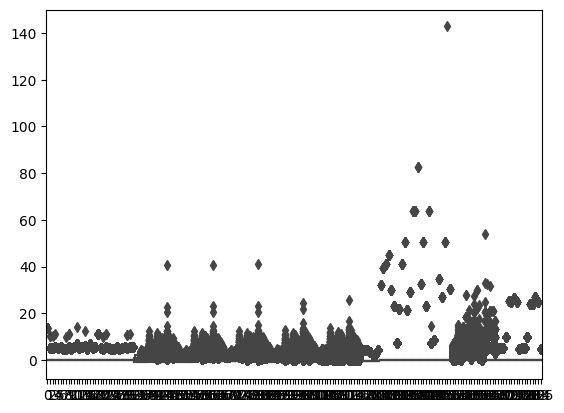

In [ ]:
# creates a stacked boxplot to examine feature distribution once feature data is scaled with StandardScaler
ss = StandardScaler()
sst = ss.fit_transform(X)
f, ax = plt.subplots()
sns.boxplot(data=sst, ax=ax)

<Axes: >

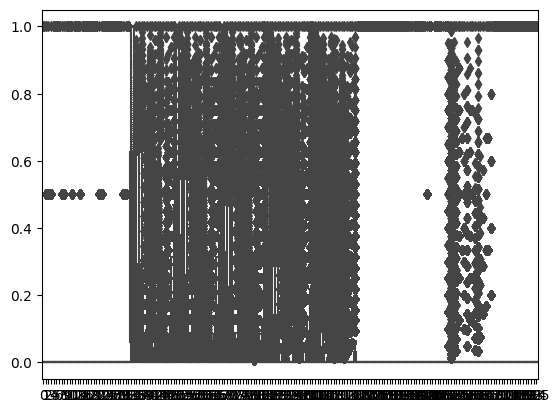

In [ ]:
# creates a stacked boxplot to examine feature distribution once feature data is scaled with MinMaxScaler
mm = MinMaxScaler()
mmt = mm.fit_transform(X)
f, ax = plt.subplots()
sns.boxplot(data=mmt, ax=ax)

<Axes: >

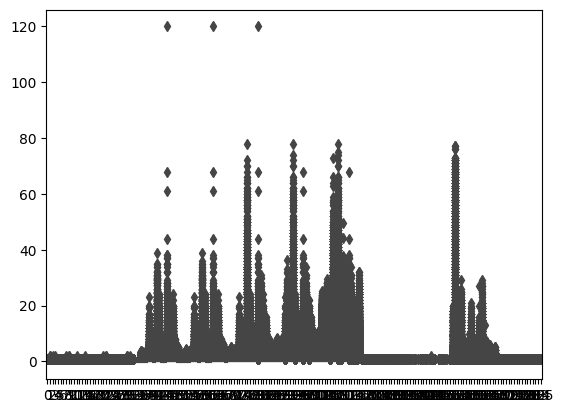

In [ ]:
# creates a stacked boxplot to examine feature distribution once feature data is scaled with RobustScaler
rs = RobustScaler()
rst = rs.fit_transform(X)
f, ax = plt.subplots()
sns.boxplot(data=rst, ax=ax)

The data was split into train and test datasets, and the features were scaled using RobustScaler, as RobustScaler accounted for outliers better than StandardScaler or MinMaxScaler

In [ ]:
# splits X (feature array) and y (target array) into train and test datasets with 80% of the data going to train and 20% of the data going to test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The dimensionality of the feature data was then reduced using PCA due to the high feature volume while including 95% of the original variance

In [ ]:
# generates a PCA that includes 95% of the original variance and fits the PCA to X_train and X_test to reduce dimensionality
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape)

(16308, 22)


After dimensionality reduction, several ensemble regressors were tested for accuracy on the training dataset with their default parameters.

In [ ]:
# tests default GradientBoostingRegressor on dataset and gives the resulting R-squared score
GradientBoostingReg = GradientBoostingRegressor().fit(X_train, y_train)
GradientBoostingReg.score(X_train, y_train)

0.3305436679508834

In [ ]:
# tests default AdaBoostRegressor on dataset and gives the resulting R-squared score
AdaBoostReg = AdaBoostRegressor().fit(X_train, y_train)
AdaBoostReg.score(X_train, y_train)

-1.159143589024827

In [ ]:
# tests default RandomForestRegressor on dataset and gives the resulting R-squared score
RandomForestReg = RandomForestRegressor().fit(X_train, y_train)
RandomForestReg.score(X_train, y_train)

0.7439620621862517

In [ ]:
# tests default ExtraTreesRegressor on dataset and gives the resulting R-squared score
ExtraTreesReg = ExtraTreesRegressor().fit(X_train, y_train)
ExtraTreesReg.score(X_train, y_train)

0.8218860632366923

In [ ]:
# tests default XGBRegressor on dataset and gives the resulting R-squared score
XGBReg = XGBRegressor().fit(X_train, y_train)
XGBReg.score(X_train, y_train)

0.6367207660949761

In [ ]:
# tests default BaggingRegressor on dataset and gives the resulting R-squared score
BaggingReg = BaggingRegressor().fit(X_train, y_train)
BaggingReg.score(X_train, y_train)

0.7153902236146048

In [ ]:
# tests default HistGradientBoostingRegressor on dataset and gives the resulting R-squared score
HistGradientBoostingReg = HistGradientBoostingRegressor().fit(X_train, y_train)
HistGradientBoostingReg.score(X_train, y_train)

0.3528998201106036

Of the ensemble regression models, ExtraTrees, RandomForest, and Bagging regressors showed the most promise. Hyperparameter tuning will be performed to attempt to optimize these models.

In [ ]:
# gets default parameters from RandomForestReg
RandomForestReg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# performs cross-validated search and gives the optimum tuning of parameters within the given grid and the resulting model R-squared score
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
gsearch = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = param_grid, scoring='r2')
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 6,
  'max_features': None,
  'max_leaf_nodes': 9,
  'n_estimators': 100},
 0.26272016392129915)

In [ ]:
# gets default parameters from ExtraTreesReg
ExtraTreesReg.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# performs cross-validated search and gives the optimum tuning of parameters within the given grid and the resulting model R-squared score
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(),
                        param_grid = param_grid, scoring='r2')
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 9,
  'max_features': None,
  'max_leaf_nodes': 9,
  'n_estimators': 50},
 0.21874649153219444)

In [ ]:
# gets default parameters from BaggingReg
BaggingReg.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# performs cross-validated search and gives an optimum tuning of parameters within the given grid and the resulting model R-squared score
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800],
    'max_features': [0.90, 0.92, 0.95, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

gsearch = RandomizedSearchCV(estimator = BaggingRegressor(),
                        param_distributions = param_grid, n_iter=15, n_jobs=-1, scoring='r2', cv=3)

gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'n_estimators': 800,
  'max_features': 0.92,
  'bootstrap_features': True,
  'bootstrap': True},
 0.2561094785665932)

Since hyperparameter tuning did not improve any of the 3 top models, Voting and Stacking regressors will be tested to see if accuracy improves.

In [ ]:
# creates VotingRegressor model from the previoust RandomForest, ExtraTrees, and Bagging regressors and gives the resulting R-squared score
RandomForestReg = RandomForestRegressor()
ExtraTreesReg = ExtraTreesRegressor()
BaggingReg = BaggingRegressor()

regs = [('rdm', RandomForestReg),
        ('ext', ExtraTreesReg),
        ('bag', BaggingReg)]

VotingReg = VotingRegressor(regs).fit(X_train, y_train)
VotingReg.score(X_train, y_train)

0.7845358599562431

In [ ]:
# creates StackingRegressor model from the previoust RandomForest, ExtraTrees, and Bagging regressors and gives the resulting R-squared score
StackingReg = StackingRegressor(estimators=regs).fit(X_train, y_train)
StackingReg.score(X_train, y_train)

0.7108835592713032

Since the original project which formed the basis for this analysis used RMSE, the RMSE of the two most accurate models (ExtraTreesRegressor and VotingRegressor) on the training data was determined.

In [ ]:
# calculated root-mean squared error (RMSE) for the ExtraTrees model on the training data
y_train_pred = ExtraTreesReg.predict(X_train)
rmse = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
print(rmse)

0.1439636236476365


In [ ]:
# calculated root-mean squared error (RMSE) for the Voting model on the training data
y_train_pred = VotingReg.predict(X_train)
rmse = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
print(rmse)

0.15834024710700526


Since ExtraTreesRegressor had the highest R-squared score on the dataset and the lowest RMSE between itself and the voting regressor, ExtraTreesRegressor was chosen as the final model

# Final Model Evaluation

Text(0, 0.5, 'Actual Value')

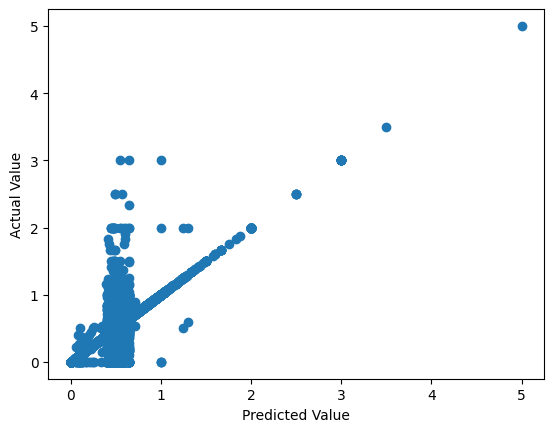

In [ ]:
# creates a scatterplot of predicted y_train values vs actual y_train values for ExtraTreesReg to visualize the regression model
y_train_pred = ExtraTreesReg.predict(X_train)
plt.scatter(y_train_pred, y_train)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

The residuals plot does not have pure randomness, which indicates the possibility of uncaptured exploratory information

Text(0, 0.5, 'Residuals')

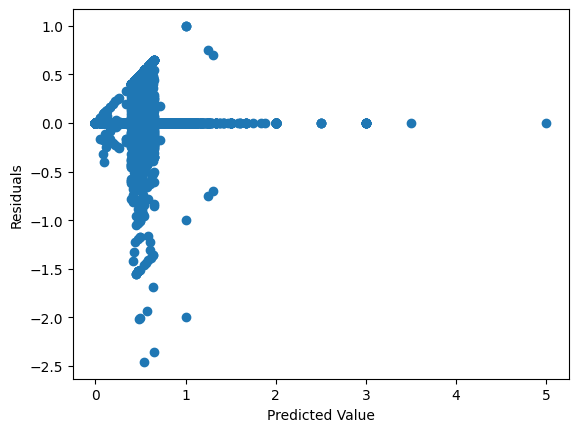

In [ ]:
# creates a residual plot for ExtraTreesReg to explore if there is evidence of uncaptured exploratory information
y_diff = y_train_pred - y_train
plt.scatter(y_train_pred, y_diff)
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')

The model does not have predictive validity, as the R-squared score is 0.206 and the RMSE is 0.306 for the test dataset.

In [ ]:
# Finds the ExtraTreesReg model's R-squared score on the test data
ExtraTreesReg.score(X_test, y_test)

0.20626171528812043

In [ ]:
# calculated root-mean squared error (RMSE) for the ExtraTreesReg model on the test data
y_test_pred = ExtraTreesReg.predict(X_test)
rmse = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
print(rmse)

0.3056559230281802


The scatterplot of predicted test data vs actual test data shows a poorly fit model

Text(0, 0.5, 'Actual Value')

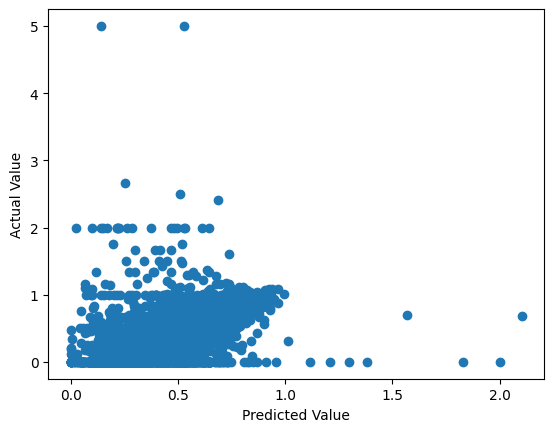

In [ ]:
# creates a scatterplot to visualize the poor fit between the ExtraTreesReg model and the test data
plt.scatter(y_test_pred, y_test)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')